In [1]:
%matplotlib notebook

import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix

SEED = 42
np.random.seed(SEED)

In [2]:
# Read in data
loan_data_filename = 'training_data.csv'
loan_data = pd.read_csv(loan_data_filename, skiprows=1)

/Users/ankurmanikandan/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (3,4,5,6,8,9,10,16) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Goal

**To build a model that predicts at `application time` whether an applicant will repay the loan they are requesting.**

# Step1: Explore the data

In [3]:
loan_data.head(10)

,id,member_id,loan_amnt,term,int_rate,emp_length,home_ownership,annual_inc,loan_status,desc,...,bc_util,dti,inq_last_6mths,mths_since_recent_inq,revol_util,total_bc_limit,total_pymnt,mths_since_last_major_derog,tot_hi_cred_lim,tot_cur_bal
0,10129403,11981032.0,7550,36 months,16.24%,3 years,RENT,28000.0,Current,NaN,...,96.0,8.40,0.0,17.0,72%,4000.0,1864.38,NaN,3828.953801,5759.0
1,10149342,12000897.0,27050,36 months,10.99%,10+ years,OWN,55000.0,Current,Borrower added on 12/31/13 > Combining high ...,...,53.9,22.87,0.0,8.0,61.2%,35700.0,6198.22,NaN,34359.940727,114834.0
2,10129454,11981072.0,12000,36 months,10.99%,4 years,RENT,60000.0,Current,Borrower added on 12/31/13 > I would like to...,...,15.9,4.62,1.0,3.0,24%,18100.0,2748.84,NaN,16416.617758,7137.0
3,10149577,12001118.0,28000,36 months,7.62%,5 years,MORTGAGE,325000.0,Fully Paid,NaN,...,67.1,18.55,1.0,3.0,54.6%,42200.0,29150.98,NaN,38014.149757,799592.0
4,10139658,11991209.0,12000,36 months,13.53%,10+ years,RENT,40000.0,Current,NaN,...,79.6,16.94,0.0,17.0,68.8%,7000.0,2851.80,53.0,6471.462236,13605.0
5,10119590,11971211.0,11500,60 months,22.90%,4 years,RENT,32760.0,Current,Borrower added on 12/31/13 > This loan is fo...,...,70.1,27.06,0.0,14.0,70.9%,9000.0,2264.66,NaN,9750.303073,24724.0
6,10149488,12001033.0,4800,36 months,10.99%,2 years,MORTGAGE,39600.0,Current,Borrower added on 12/31/13 > Just bought a h...,...,16.1,2.49,2.0,3.0,16.1%,25700.0,1257.04,NaN,24491.154755,4136.0
7,10159611,12011228.0,10000,36 months,9.67%,7 years,MORTGAGE,102000.0,Current,NaN,...,89.4,15.55,0.0,8.0,44.4%,9200.0,2247.60,54.0,9401.851428,39143.0
8,10129506,11981122.0,20800,36 months,13.53%,10+ years,RENT,81500.0,Current,Borrower added on 12/31/13 > My goal is to p...,...,54.6,16.73,2.0,0.0,54.5%,15000.0,4942.08,71.0,15014.232744,23473.0
9,10149526,12001069.0,27600,60 months,19.97%,6 years,MORTGAGE,73000.0,Current,Borrower added on 12/31/13 > I had some wate...,...,74.7,23.13,1.0,6.0,82.8%,19200.0,5114.91,7.0,20011.337149,241609.0


In [4]:
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197787 entries, 0 to 197786
Data columns (total 22 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           197787 non-null  int64  
 1   member_id                    188123 non-null  float64
 2   loan_amnt                    197787 non-null  int64  
 3   term                         188123 non-null  object 
 4   int_rate                     188123 non-null  object 
 5   emp_length                   180246 non-null  object 
 6   home_ownership               188123 non-null  object 
 7   annual_inc                   188123 non-null  float64
 8   loan_status                  188123 non-null  object 
 9   desc                         81461 non-null   object 
 10  purpose                      188123 non-null  object 
 11  percent_bc_gt_75             179096 non-null  float64
 12  bc_util                      179012 non-null  float64
 13 

## Investigate outcome variable: 'loan_status'

In the challenge we have been asked to develop a predictive model to determine whether the applicant will be able to repay the loan. 'loan_status' column contains this information. Let's investigate it.

In [5]:
loan_data.total_pymnt.isna().sum()

9664

In [6]:
# Loan Status
loan_data.loan_status.value_counts(dropna=False)

Current               140116
Fully Paid             33309
NaN                     9664
Charged Off             9178
Late (31-120 days)      3077
In Grace Period         1570
Late (16-30 days)        780
Default                   93
Name: loan_status, dtype: int64

1. **Current:** There are quite a few loans that are on-going. Is this useful to us? Yes, since these loans have not been defaulted, we can leverage this valuable information. We can consider this category of loan status as `non-default` (since the borrower has not defaulted on them, yet). 
    
        a. But we need to be a bit careful - one can argue that, the loan status will be 'Current' even when the loan has just been approved and the borrower's payment due date has not passed. This is a very valid argument. But we can't discard so much of valuable information. 
    
        b. If we had more information, example - number of payments made on loan. We maybe able to ensure that we aren't considering loans that have just been approved. Say, we only consider loans with status 'Current' and number of minimum payments made equal to 3. 
2. **NaN:** There are missing values present in the column. Since, we have no information on the output of the loan, let's `drop all the records with missing 'loan_status' values`.
3. **Charged off:** This will be considered as `default`. 'Charged off' is considered guaranteed money lost by financial insitutions.
4. **Late (31-120 days):** This will be considered as `default`. Business policy states, all loans with status 'Late' are to be considered `default`.
5. **In Grace Period:** As long as the borrower is in the cushion period provided by the business, he/she is safe and therefore considered as `non-default`.
6. **Default:** Well, not much to say here, the status itself is `default`.

### Assign labels 0 (non-default) and 1 (default) to each record

Before we assign the labels, we need to drop the records with missing values in the `loan_status` column.

In [7]:
# Drop records
loan_data.dropna(subset=['loan_status'], inplace=True)

In [8]:
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 188123 entries, 0 to 188122
Data columns (total 22 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           188123 non-null  int64  
 1   member_id                    188123 non-null  float64
 2   loan_amnt                    188123 non-null  int64  
 3   term                         188123 non-null  object 
 4   int_rate                     188123 non-null  object 
 5   emp_length                   180246 non-null  object 
 6   home_ownership               188123 non-null  object 
 7   annual_inc                   188123 non-null  float64
 8   loan_status                  188123 non-null  object 
 9   desc                         81461 non-null   object 
 10  purpose                      188123 non-null  object 
 11  percent_bc_gt_75             179096 non-null  float64
 12  bc_util                      179012 non-null  float64
 13 

In [9]:
# Assign labels
default_categories = ['Charged Off', 'Late (31-120 days)', 'Late (16-30 days)', 'Default']
loan_data['loan_status_int'] = np.where(loan_data.loan_status.isin(default_categories), 1, 0)
loan_data.loan_status_int.value_counts(dropna=False)

0    174995
1     13128
Name: loan_status_int, dtype: int64

Now that we have our labels ready, let's explore the other variables to determine their predictive power. 

### Investigate 'id' and 'member_id' columns

**Let's drop the 'id' and 'member_id' column.** Based on the values, we can safely determine that they do not offer any predictive power.

In [10]:
# Drop 'id' and 'member_id' columns
loan_data.drop(columns=['id', 'member_id'], inplace=True)

### Investigate 'loan_amnt' and its relationship with the outcome variable

In [11]:
# Function to plot continuous values against the outcome variable
def plot_cont_against_label(col):
    
    fig, ax = plt.subplots(nrows=1, ncols=2)
    loan_data.loc[loan_data.loan_status_int == 0, col].plot.hist(
        bins=50, alpha=0.4, color='g', label='no-default', density=True, ax=ax[0])
    loan_data.loc[loan_data.loan_status_int == 1, col].plot.hist(
        bins=50, alpha=0.4, color='r', label='default', density=True, ax=ax[0])
    ax[0].set_title(col + ' vs. Default status')
    ax[0].legend()
    
    loan_data.boxplot(column=col, by='loan_status_int', ax=ax[1])
    ax[1].set_title(col + ' grouped by labels')

    fig.suptitle(col)
    plt.show()

<IPython.core.display.Javascript object>


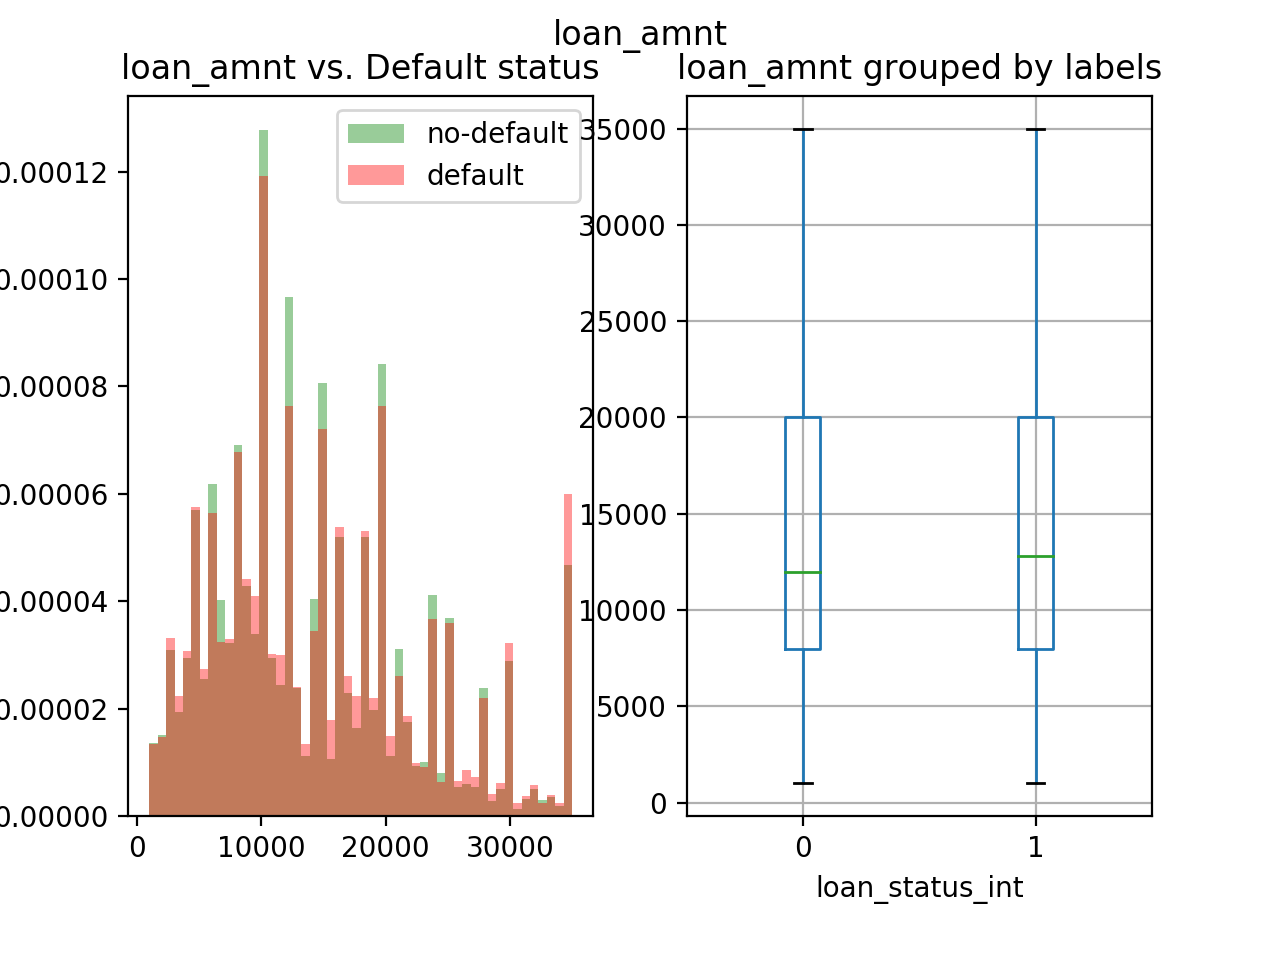

In [12]:
plot_cont_against_label('loan_amnt')

What we learn from the above plots are:
1. Loan have been defaulted irrespective of the amount - small amounts, like \\$1,500, to large amounts, like \\$30,000.
2. The number of loans defaulted with amounts greater than \\$25,000 is greater than the non-defaulted loans.
3. The mean of the loan amounts that have defaulted is slightly greater than non-defaulted loans.

### Investigate 'term' and compare it with the labels

In [13]:
loan_data.term.value_counts(dropna=False)

 36 months    143850
 60 months     44273
Name: term, dtype: int64

In [14]:
# Function to plot categorical variables against the outcome variable
def plot_cat_against_label(col):
    
    fig, ax = plt.subplots()
    pd.crosstab(loan_data[col], loan_data.loan_status_int).plot.bar(ax=ax)
    plt.title(col + 'vs. default status')
    plt.xticks(rotation=360)
    plt.show()

<IPython.core.display.Javascript object>


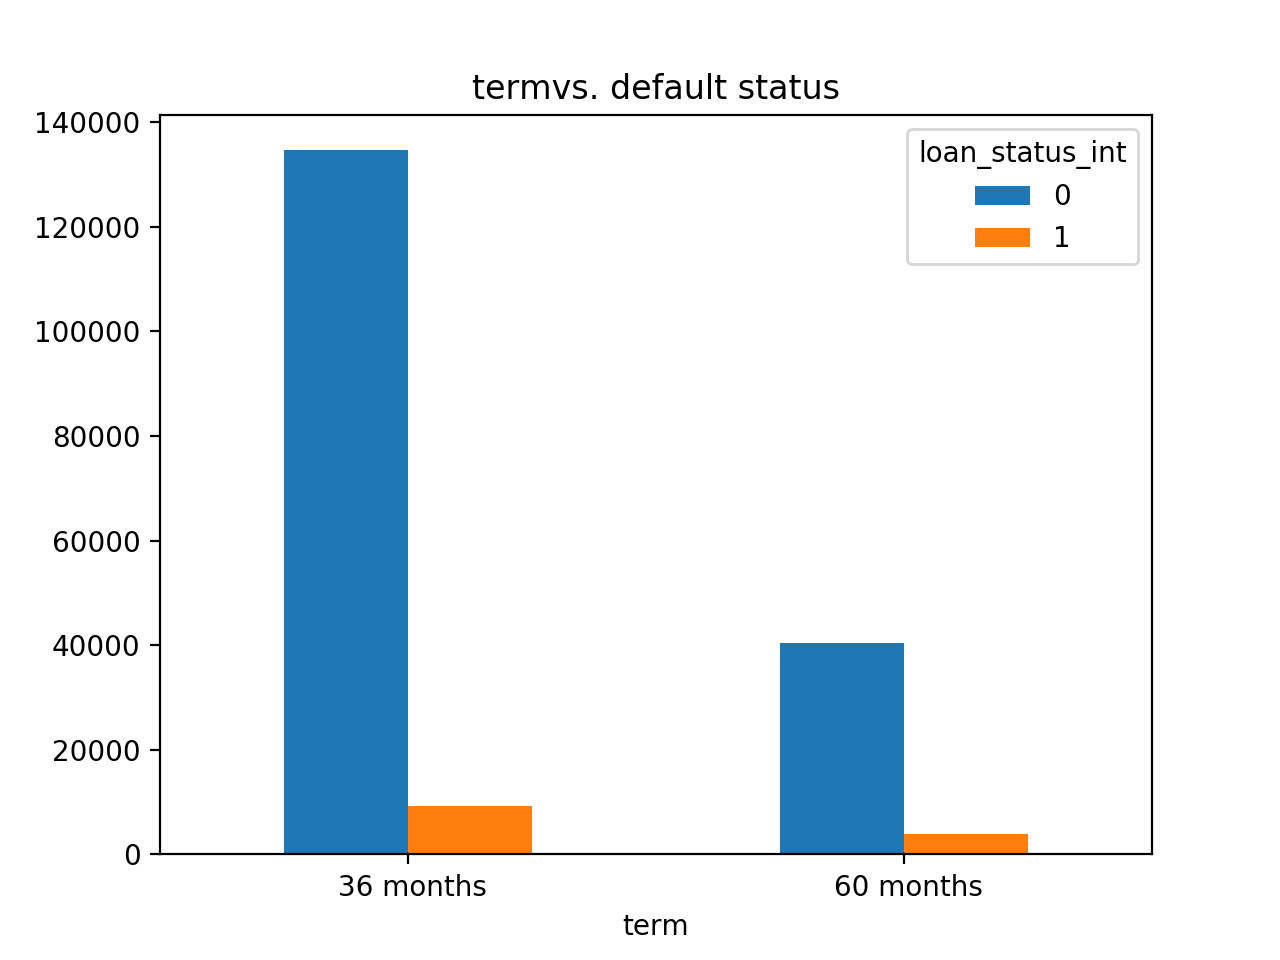

In [15]:
plot_cat_against_label('term')

In [16]:
# Get the proportions of term loans vs. loan status
temp_var = loan_data.groupby(['term', 'loan_status_int'])['loan_amnt'].count()
print(temp_var)
print("\nProportion of 36-month loans vs. loan status", 
      temp_var.loc[(' 36 months')]/temp_var.loc[(' 36 months')].sum())
print("\nProportion of 60-month loans vs. loan status", 
      temp_var.loc[(' 60 months')]/temp_var.loc[(' 60 months')].sum())

term        loan_status_int
 36 months  0                  134594
            1                    9256
 60 months  0                   40401
            1                    3872
Name: loan_amnt, dtype: int64

Proportion of 36-month loans vs. loan status loan_status_int
0    0.935655
1    0.064345
Name: loan_amnt, dtype: float64

Proportion of 60-month loans vs. loan status loan_status_int
0    0.912543
1    0.087457
Name: loan_amnt, dtype: float64


What we learn from the above plot:

1. The number of defaulted loans with term 36 months is greater than loans with 60 amounts. But that makes sense because the proportion of defaulted 36-term loans is approximately equal to the number of defaulted 60-term loans.

### Investigate 'int_rate'

At application time, the interest rate is not determined. **Therefore let's drop the `int_rate` column.**

In [17]:
loan_data.drop(columns='int_rate', inplace=True)

### Investigate 'emp_length'

In [18]:
loan_data.emp_length.value_counts(dropna=False)

10+ years    61175
2 years      16143
5 years      14265
3 years      13965
< 1 year     13222
6 years      11916
1 year       11434
7 years      11207
4 years      10846
8 years       8950
NaN           7877
9 years       7123
Name: emp_length, dtype: int64

In [19]:
# Investigate the NaN values in employment length
loan_data.loc[loan_data.emp_length.isna(), 'loan_status_int'].value_counts()

0    7220
1     657
Name: loan_status_int, dtype: int64

In [20]:
# Investigate the NaN values against the loan purpose
loan_data.loc[loan_data.emp_length.isna(), 'purpose'].value_counts(dropna=False)

debt_consolidation    4136
credit_card           2049
home_improvement       563
other                  548
major_purchase         166
medical                 90
car                     85
vacation                56
small_business          53
moving                  53
house                   51
wedding                 19
renewable_energy         8
Name: purpose, dtype: int64

In [21]:
loan_data.loc[loan_data.emp_length.isna(), 'loan_status_int'].value_counts()\
    /loan_data.loc[loan_data.emp_length.isna(), 'loan_status_int'].count()

0    0.916593
1    0.083407
Name: loan_status_int, dtype: float64

In [22]:
uniq_cat = loan_data.emp_length.unique()
for cat in uniq_cat:
    print("\n", cat)
    print(loan_data.loc[loan_data.emp_length == cat, 'loan_status_int'].value_counts()\
              /loan_data.loc[loan_data.emp_length == cat, 'loan_status_int'].count())


 3 years
0    0.930469
1    0.069531
Name: loan_status_int, dtype: float64

 10+ years
0    0.938766
1    0.061234
Name: loan_status_int, dtype: float64

 4 years
0    0.920155
1    0.079845
Name: loan_status_int, dtype: float64

 5 years
0    0.927655
1    0.072345
Name: loan_status_int, dtype: float64

 2 years
0    0.928762
1    0.071238
Name: loan_status_int, dtype: float64

 7 years
0    0.92933
1    0.07067
Name: loan_status_int, dtype: float64

 6 years
0    0.923212
1    0.076788
Name: loan_status_int, dtype: float64

 1 year
0    0.928721
1    0.071279
Name: loan_status_int, dtype: float64

 9 years
0    0.929945
1    0.070055
Name: loan_status_int, dtype: float64

 < 1 year
0    0.918469
1    0.081531
Name: loan_status_int, dtype: float64

 8 years
0    0.932179
1    0.067821
Name: loan_status_int, dtype: float64

 nan
Series([], Name: loan_status_int, dtype: float64)


So we do have NaNs in the `emp_length` column. But we can't drop these records, because that would lead to the loss of 657 default records. Let's assign 'missing' in place of the NaNs. 

In [23]:
loan_data.emp_length.fillna('missing', inplace=True)
loan_data.emp_length.value_counts(dropna=False)

10+ years    61175
2 years      16143
5 years      14265
3 years      13965
< 1 year     13222
6 years      11916
1 year       11434
7 years      11207
4 years      10846
8 years       8950
missing       7877
9 years       7123
Name: emp_length, dtype: int64

### Investigate 'home_ownership'

In [24]:
loan_data.home_ownership.value_counts(dropna=False)

MORTGAGE    96979
RENT        75609
OWN         15447
OTHER          46
NONE           42
Name: home_ownership, dtype: int64

<IPython.core.display.Javascript object>


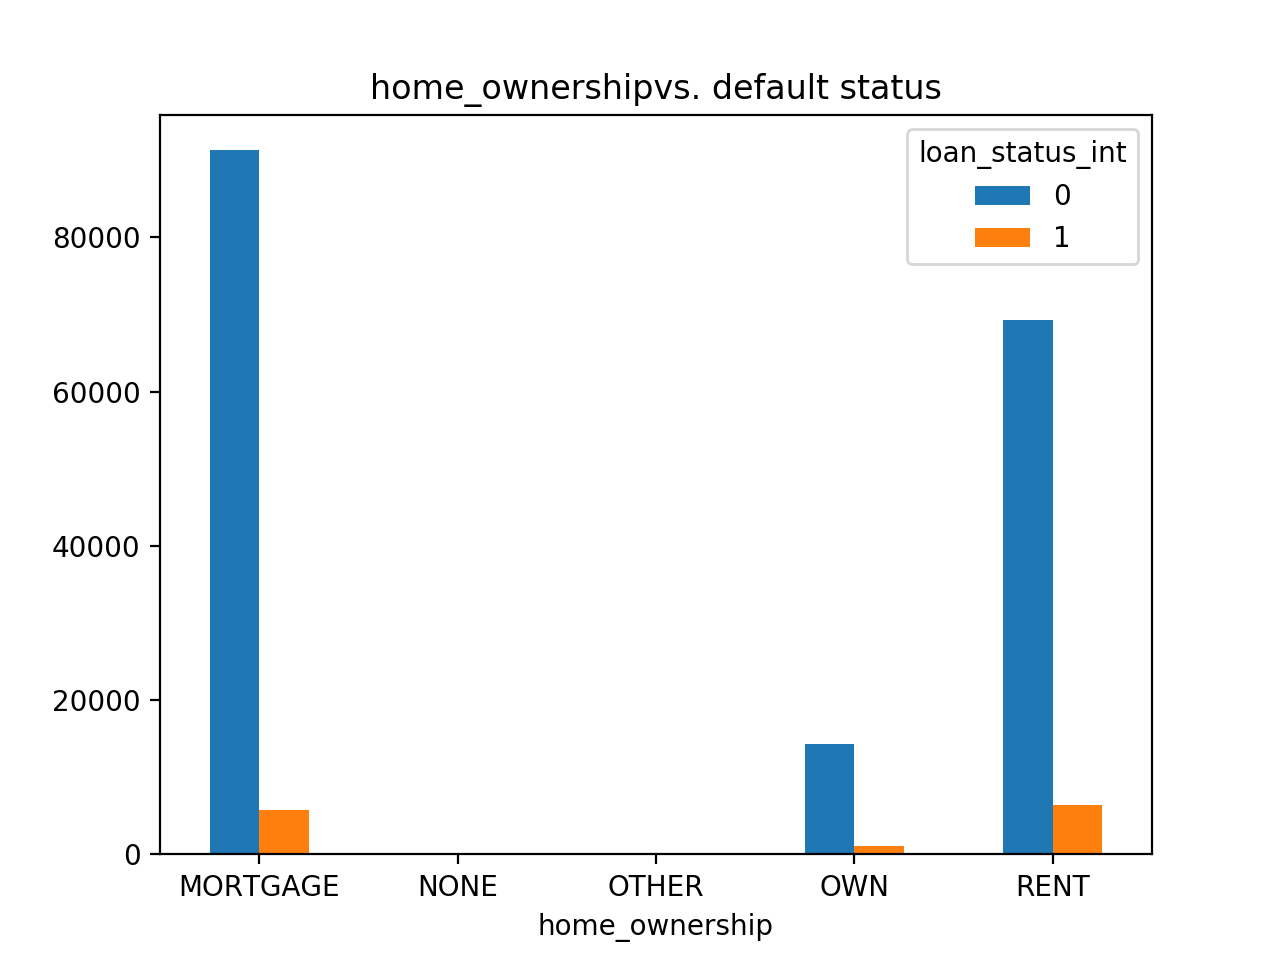

In [25]:
plot_cat_against_label('home_ownership')

In [26]:
loan_data.groupby(['home_ownership', 'loan_status_int'])['loan_status_int'].count()

home_ownership  loan_status_int
MORTGAGE        0                  91285
                1                   5694
NONE            0                     38
                1                      4
OTHER           0                     41
                1                      5
OWN             0                  14363
                1                   1084
RENT            0                  69268
                1                   6341
Name: loan_status_int, dtype: int64

In [27]:
uniq_cat = loan_data.home_ownership.unique()
for cat in uniq_cat:
    print("\n", cat)
    print(loan_data.loc[loan_data.home_ownership == cat, 'loan_status_int'].value_counts()\
              /loan_data.loc[loan_data.home_ownership == cat, 'loan_status_int'].count())


 RENT
0    0.916134
1    0.083866
Name: loan_status_int, dtype: float64

 OWN
0    0.929825
1    0.070175
Name: loan_status_int, dtype: float64

 MORTGAGE
0    0.941286
1    0.058714
Name: loan_status_int, dtype: float64

 NONE
0    0.904762
1    0.095238
Name: loan_status_int, dtype: float64

 OTHER
0    0.891304
1    0.108696
Name: loan_status_int, dtype: float64


We can see that `MORTGAGE` has the least number of default loans. The rest of the home ownership types have similar percentage of default lines.

### Investigate 'annual_inc'

<IPython.core.display.Javascript object>


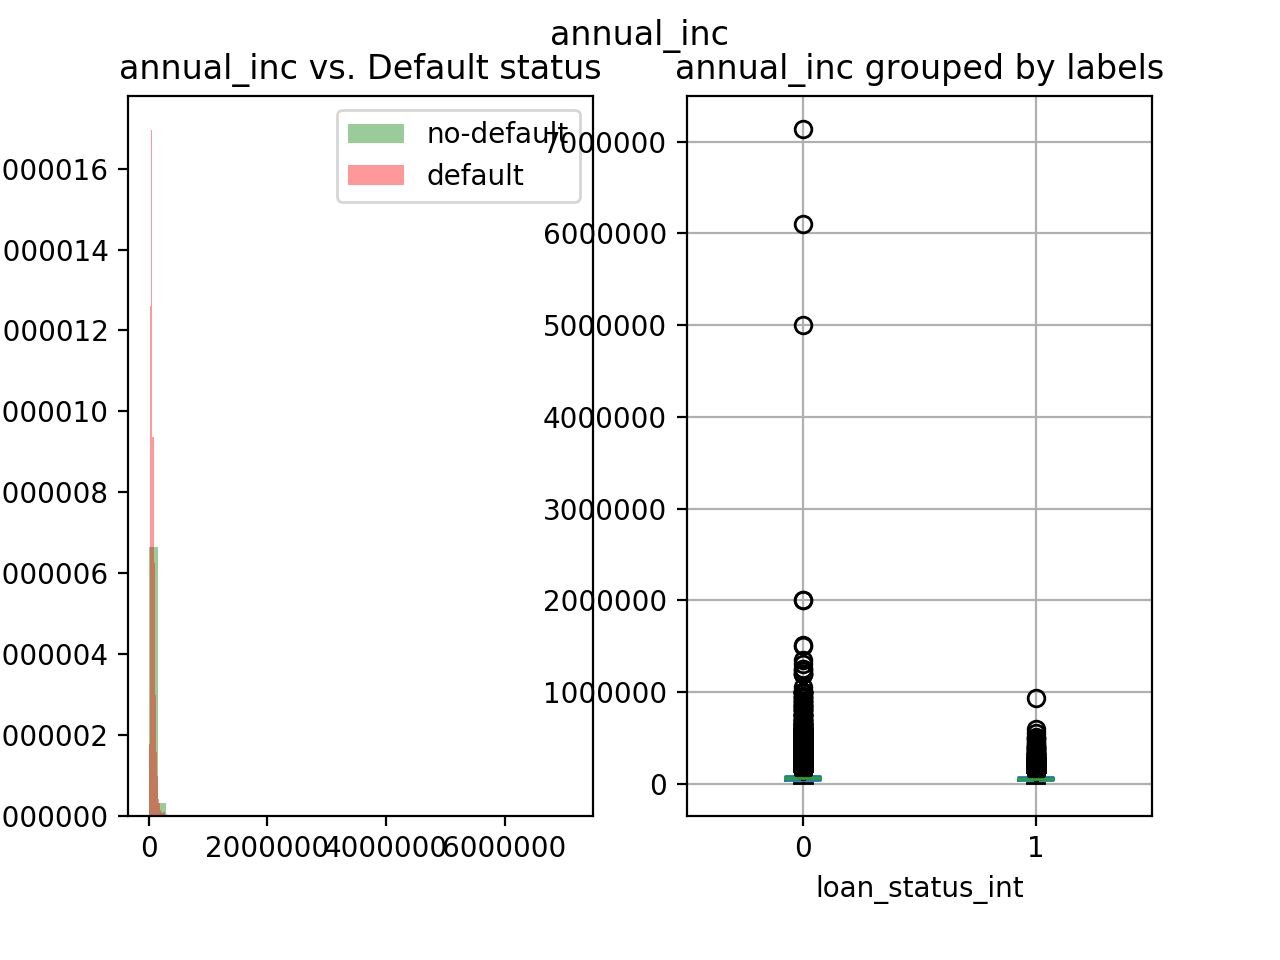

In [28]:
plot_cont_against_label('annual_inc')

In [29]:
loan_data.groupby('loan_status_int')['annual_inc'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status_int,,,,,,,,
0,174995.0,72826.135705,52636.624398,4800.0,45000.0,63000.0,88000.0,7141778.0
1,13128.0,64408.371835,38684.723398,4800.0,40000.0,55000.0,78000.0,932000.0


1. The mean and the spread of the annual income is smaller for the default loans relative to non-default loans.
2. Additionally, members with annual incomes greater than \\$932,000 have not defaulted on their loans.

### Investigate 'desc' and 'purpose'

In [30]:
loan_data[['desc', 'purpose']].head(10)

,desc,purpose
0,NaN,debt_consolidation
1,Borrower added on 12/31/13 > Combining high ...,debt_consolidation
2,Borrower added on 12/31/13 > I would like to...,debt_consolidation
3,NaN,debt_consolidation
4,NaN,debt_consolidation
5,Borrower added on 12/31/13 > This loan is fo...,debt_consolidation
6,Borrower added on 12/31/13 > Just bought a h...,home_improvement
7,NaN,debt_consolidation
8,Borrower added on 12/31/13 > My goal is to p...,debt_consolidation
9,Borrower added on 12/31/13 > I had some wate...,debt_consolidation


In [31]:
loan_data.purpose.value_counts(dropna=False)

debt_consolidation    111436
credit_card            43143
home_improvement       10293
other                   8891
major_purchase          3655
small_business          2744
car                     1950
medical                 1518
wedding                 1330
house                   1093
moving                  1038
vacation                 910
renewable_energy         122
Name: purpose, dtype: int64

`purpose` is more succinct than `desc.`. We can use the `purpose` column in place of the `desc` column.

In [32]:
# Drop the 'description' column
loan_data.drop(columns=['desc'], inplace=True)

### Investigate 'percent_bc_gt_75'

In [33]:
loan_data.percent_bc_gt_75.describe()

count    179096.000000
mean         53.557030
std          34.148464
min           0.000000
25%          25.000000
50%          50.000000
75%          80.000000
max         100.000000
Name: percent_bc_gt_75, dtype: float64

In [34]:
loan_data.groupby('loan_status_int')['percent_bc_gt_75'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status_int,,,,,,,,
0,167175.0,53.110501,34.164196,0.0,25.0,50.0,80.0,100.0
1,11921.0,59.818958,33.303624,0.0,33.3,66.7,100.0,100.0


<IPython.core.display.Javascript object>


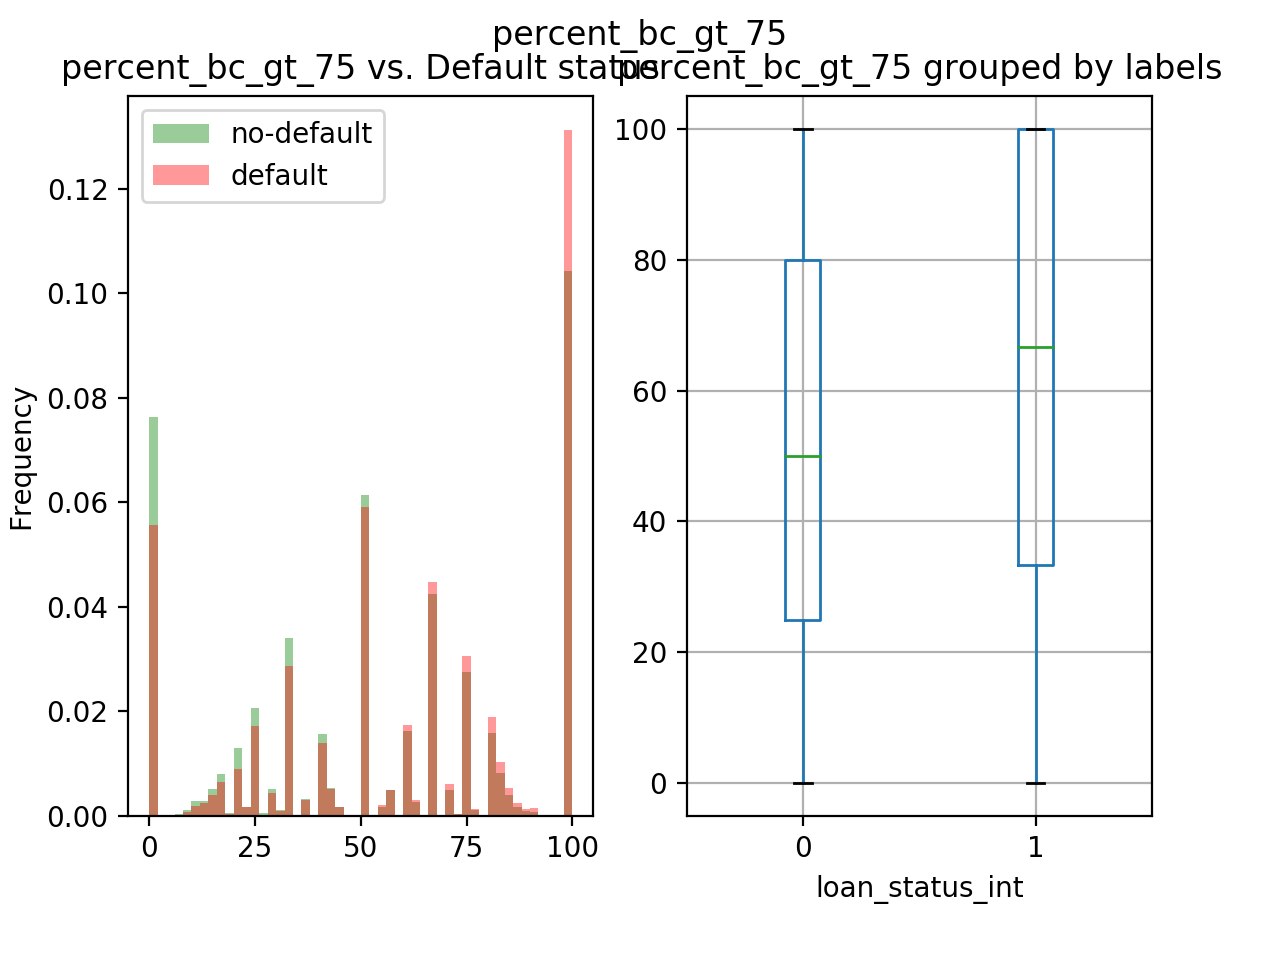

In [35]:
plot_cont_against_label('percent_bc_gt_75')

In [36]:
# Lastly, let's check if there are any missing values
loan_data.percent_bc_gt_75.isna().sum()

9027

In [37]:
# Missing values against the loan status
print(loan_data.loc[loan_data.percent_bc_gt_75.isna(), 'loan_status_int'].value_counts())

0    7820
1    1207
Name: loan_status_int, dtype: int64


In [38]:
# Let's fill in the missing values with the median of default and non-default loans
loan_data.loc[(loan_data.percent_bc_gt_75.isna()) & (loan_data.loan_status_int == 0), 'percent_bc_gt_75'] \
    = loan_data.groupby('loan_status_int')['percent_bc_gt_75'].describe().loc[0, '50%']
loan_data.loc[(loan_data.percent_bc_gt_75.isna()) & (loan_data.loan_status_int == 1), 'percent_bc_gt_75'] \
    = loan_data.groupby('loan_status_int')['percent_bc_gt_75'].describe().loc[1, '50%']
print(loan_data.percent_bc_gt_75.isna().sum())

0


In [39]:
loan_data.groupby('loan_status_int')['percent_bc_gt_75'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status_int,,,,,,,,
0,174995.0,52.971502,33.398304,0.0,25.0,50.0,80.0,100.0
1,13128.0,60.451607,31.797837,0.0,40.0,66.7,85.7,100.0


Borrowers with a high utilization tend to default on the loans. We can see from the above plots

1. For values greater than 60, the number of loan defaults are higher, as expected. Higher the `percent_bc_gt_75` greater the likelihood of default.
2. The summary statistics of `percent_bc_gt_75` for default loans are higher as well.
3. More importantly, the 75th percentile for default loans is 100 percent of the limit.

### Investigate 'bc_util'

In [40]:
loan_data.bc_util.describe()

count    179012.000000
mean         66.829415
std          26.110808
min           0.000000
25%          49.500000
50%          72.200000
75%          89.000000
max         339.600000
Name: bc_util, dtype: float64

<IPython.core.display.Javascript object>


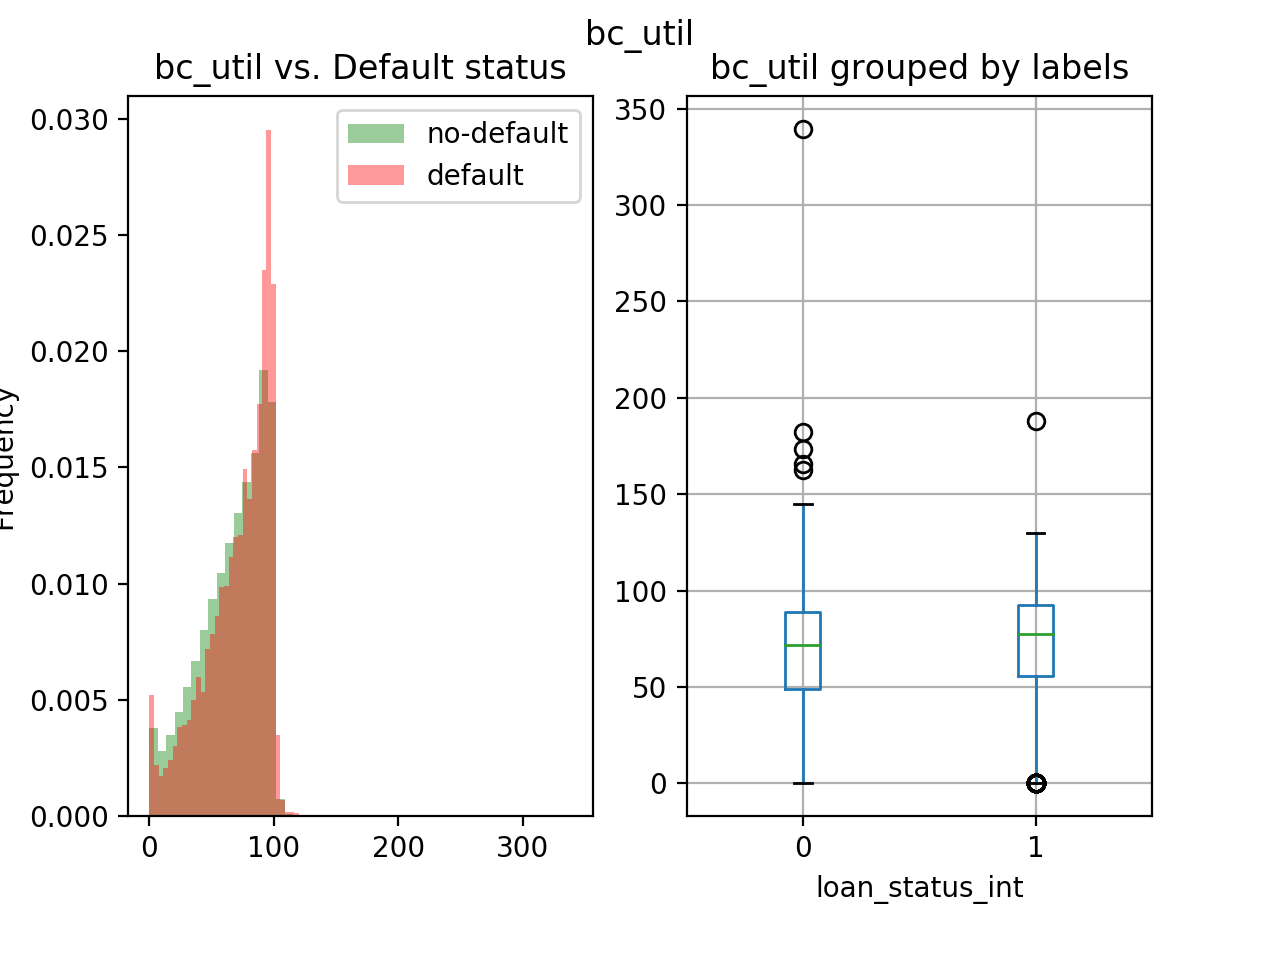

In [41]:
plot_cont_against_label('bc_util')

In [42]:
loan_data.groupby('loan_status_int')['bc_util'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status_int,,,,,,,,
0,167101.0,66.528825,26.106843,0.0,49.10,71.8,88.7,339.6
1,11911.0,71.046428,25.800859,0.0,55.65,77.6,92.5,187.9


In [43]:
loan_data.bc_util.isna().sum()

9111

In [44]:
# Let's fill in the missing values with the median of default and non-default loans
loan_data.loc[(loan_data.bc_util.isna()) & (loan_data.loan_status_int == 0), 'bc_util'] \
    = loan_data.groupby('loan_status_int')['bc_util'].describe().loc[0, '50%']
loan_data.loc[(loan_data.bc_util.isna()) & (loan_data.loan_status_int == 1), 'bc_util'] \
    = loan_data.groupby('loan_status_int')['bc_util'].describe().loc[1, '50%']
print(loan_data.bc_util.isna().sum())

0


In [45]:
loan_data.groupby('loan_status_int')['bc_util'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status_int,,,,,,,,
0,174995.0,66.766607,25.534653,0.0,50.4,71.8,88.0,339.6
1,13128.0,71.653961,24.649171,0.0,58.3,77.6,91.4,187.9


### Investigate 'revol_util'

In [46]:
loan_data.revol_util.head(10)

0      72%
1    61.2%
2      24%
3    54.6%
4    68.8%
5    70.9%
6    16.1%
7    44.4%
8    54.5%
9    82.8%
Name: revol_util, dtype: object

In [47]:
# Need to extract the digits
loan_data.revol_util = loan_data.revol_util.str.replace('%', '').astype(float)
loan_data.revol_util.describe()

count    187998.000000
mean         58.386538
std          23.009050
min           0.000000
25%          42.500000
50%          60.500000
75%          76.600000
max         140.400000
Name: revol_util, dtype: float64

<IPython.core.display.Javascript object>


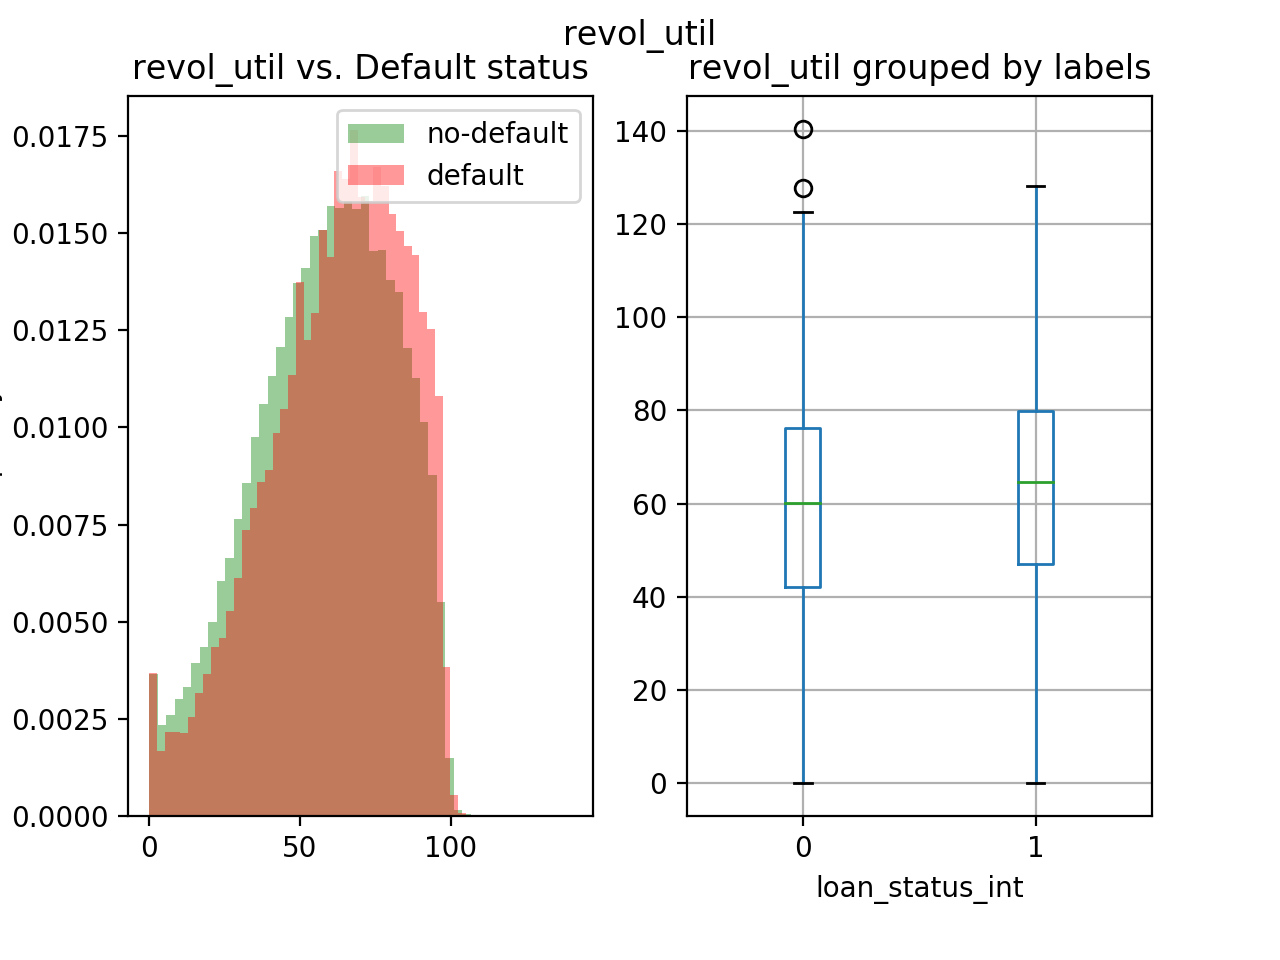

In [48]:
plot_cont_against_label('revol_util')

In [49]:
loan_data.revol_util.isna().sum()

125

In [50]:
loan_data.groupby('loan_status_int')['revol_util'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status_int,,,,,,,,
0,174884.0,58.126311,23.003606,0.0,42.2,60.1,76.3,140.4
1,13114.0,61.856832,22.800239,0.0,47.0,64.7,79.9,128.1


In [51]:
# Let's fill in the missing values with the median of default and non-default loans
loan_data.loc[(loan_data.revol_util.isna()) & (loan_data.loan_status_int == 0), 'revol_util'] \
    = loan_data.groupby('loan_status_int')['revol_util'].describe().loc[0, '50%']
loan_data.loc[(loan_data.revol_util.isna()) & (loan_data.loan_status_int == 1), 'revol_util'] \
    = loan_data.groupby('loan_status_int')['revol_util'].describe().loc[1, '50%']
print(loan_data.revol_util.isna().sum())

0


In [52]:
loan_data.groupby('loan_status_int')['revol_util'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status_int,,,,,,,,
0,174995.0,58.127563,22.996362,0.0,42.2,60.1,76.3,140.4
1,13128.0,61.859864,22.788267,0.0,47.0,64.7,79.9,128.1


### Investigate 'mths_since_last_major_derog'

In [53]:
# Drop this column since we have very few values
loan_data.mths_since_last_major_derog.describe()

count    32497.000000
mean        41.792473
std         20.997645
min          0.000000
25%         25.000000
50%         41.000000
75%         58.000000
max        165.000000
Name: mths_since_last_major_derog, dtype: float64

In [54]:
# Missing values against the loan status
print(loan_data.loc[loan_data.mths_since_last_major_derog.isna(), 'loan_status_int'].value_counts())

0    144449
1     11177
Name: loan_status_int, dtype: int64


In [55]:
loan_data.drop(columns='mths_since_last_major_derog', inplace=True)

### Investigate 'dti'

In [56]:
loan_data.dti.describe()

count    188123.000000
mean         17.058663
std           7.596977
min           0.000000
25%          11.340000
50%          16.780000
75%          22.580000
max          34.990000
Name: dti, dtype: float64

<IPython.core.display.Javascript object>


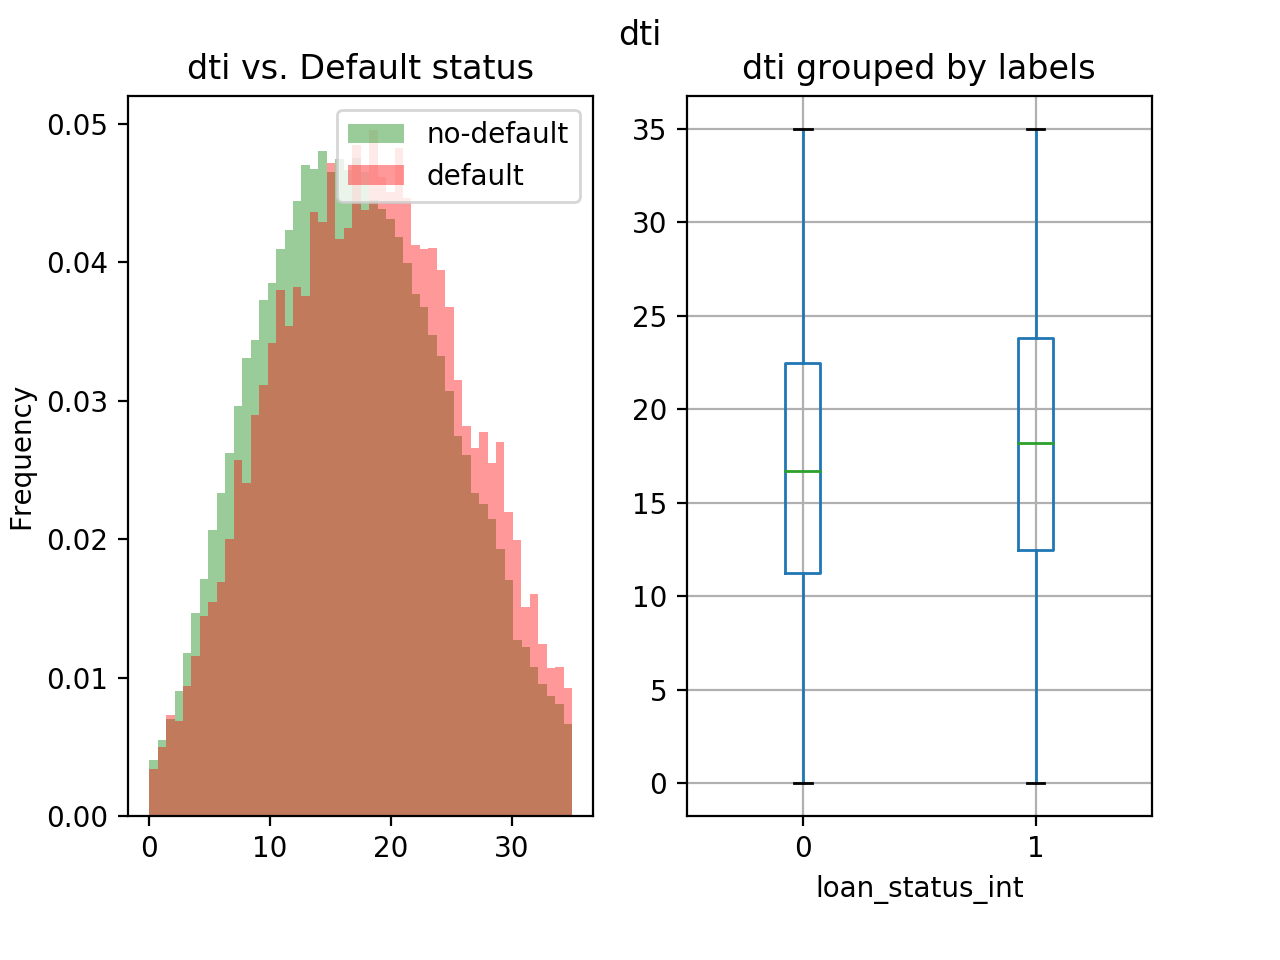

In [57]:
plot_cont_against_label('dti')

In [58]:
loan_data.dti.isna().sum()

0

## Create labels

In [59]:
# Create labels
def create_labels(df):
    
    # Drop records with loan status missing
    df.dropna(subset=['loan_status'], inplace=True)
    
    # Assign labels
    default_categories = ['Charged Off', 'Late (31-120 days)', 'Late (16-30 days)', 'Default']
    df['loan_status_int'] = np.where(df.loan_status.isin(default_categories), 1, 0)
    
    return df

## Drop columns

In [60]:
# Drop irrelevant columns
def drop_columns(df, drop_cols):
    
    return df.drop(columns=drop_cols)

## Create functions to handle missing values

In [61]:
# Handle categorical variables
def handle_missing_vals(df):
    
    # Categorical variables
    cols_cat = df.select_dtypes(include='object').columns.values
    for col_cat in cols_cat:
        if df[col_cat].isna().sum() > 0:
            print(col_cat)
            df[col_cat].fillna('missing', inplace=True)
    
    # Continuous variables
    cols_cont = df.select_dtypes(exclude='object').columns.values
    for col_cont in cols_cont:
        if df[col_cont].isna().sum() > 0:
            # Let's fill in the missing values with the median correspondin to the default and non-default loans
            df.loc[(df[col_cont].isna()) & (df.loan_status_int == 0), col_cont] \
                = df.groupby('loan_status_int')[col_cont].describe().loc[0, '50%']
            df.loc[(df[col_cont].isna()) & (df.loan_status_int == 1), col_cont] \
                = df.groupby('loan_status_int')[col_cont].describe().loc[1, '50%']
            
    return df

In [62]:
# # Handle continuous variables
# def handle_missing_vals_cont(df):
    
#     cols = df.columns.values
    
#     for col in cols:
#         if df[col].isna().sum() > 0:
#             # Let's fill in the missing values with the median correspondin to the default and non-default loans
#             df.loc[(df[col].isna()) & (df.loan_status_int == 0), col] \
#                 = df.groupby('loan_status_int')[col].describe().loc[0, '50%']
#             df.loc[(df[col].isna()) & (df.loan_status_int == 1), col] \
#                 = df.groupby('loan_status_int')[col].describe().loc[1, '50%']
            
#     return df

## Create functions to engineer features

In [63]:
# engineer categorical variables: create dummy variables
def feat_eng_cat(df, train_test_ind='train'):
    
    cols_cat = df.select_dtypes(include='object').columns.values
    
    df_dummy_vars = pd.get_dummies(df[cols_cat], prefix=cols_cat, 
                                   prefix_sep=':', drop_first=True, 
                                   columns=cols_cat)
    
    if train_test_ind == 'train':
        pickle_out = open("train_cols_cat.pickle","wb")
        train_cols_cat = df_dummy_vars.columns.values
        pickle.dump(train_cols_cat, pickle_out)
        pickle_out.close()
    else:
        pickle_in = open("train_cols_cat.pickle","rb")
        train_cols_cat = pickle.load(pickle_in)
        missing_cols = []
        for ind, val in enumerate(train_cols_cat):
            if val not in df_dummy_vars.columns:
                missing_cols.append([val, ind])
        
        if len(missing_cols) > 0:
            for i, j in missing_cols:
                df_dummy_vars.insert(j, i, 0)
        
    
    return df_dummy_vars

In [64]:
# engineer continuous variables: normalize the values
def feat_eng_cont(df, train_test_ind='train'):
    
    cols_cont = df.select_dtypes(exclude='object').columns.values
    df = df[cols_cont]
    
    scaler = StandardScaler()
    
    if train_test_ind == 'train':
        scaler.fit(df)
        pickle_out = open("scaler.pickle","wb")
        pickle.dump(scaler, pickle_out)
        pickle_out.close()
    else:
        pickle_in = open("scaler.pickle","rb")
        scaler = pickle.load(pickle_in)
        
    return scaler.transform(df) 

In [65]:
prefix = ['term', 'emp_length']
pd.get_dummies(loan_data, prefix=prefix, prefix_sep=':', drop_first=True, columns=prefix, dummy_na=True)

,loan_amnt,home_ownership,annual_inc,loan_status,purpose,percent_bc_gt_75,bc_util,dti,inq_last_6mths,mths_since_recent_inq,...,emp_length:3 years,emp_length:4 years,emp_length:5 years,emp_length:6 years,emp_length:7 years,emp_length:8 years,emp_length:9 years,emp_length:< 1 year,emp_length:missing,emp_length:nan
0,7550,RENT,28000.0,Current,debt_consolidation,100.0,96.0,8.40,0.0,17.0,...,1,0,0,0,0,0,0,0,0,0
1,27050,OWN,55000.0,Current,debt_consolidation,25.0,53.9,22.87,0.0,8.0,...,0,0,0,0,0,0,0,0,0,0
2,12000,RENT,60000.0,Current,debt_consolidation,0.0,15.9,4.62,1.0,3.0,...,0,1,0,0,0,0,0,0,0,0
3,28000,MORTGAGE,325000.0,Fully Paid,debt_consolidation,16.7,67.1,18.55,1.0,3.0,...,0,0,1,0,0,0,0,0,0,0
4,12000,RENT,40000.0,Current,debt_consolidation,33.3,79.6,16.94,0.0,17.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188118,20500,RENT,60000.0,Current,debt_consolidation,50.0,71.8,16.40,3.0,NaN,...,0,0,0,0,1,0,0,0,0,0
188119,15000,RENT,57600.0,In Grace Period,small_business,50.0,71.8,8.35,1.0,NaN,...,1,0,0,0,0,0,0,0,0,0
188120,35000,MORTGAGE,160000.0,Current,small_business,50.0,71.8,4.90,1.0,NaN,...,1,0,0,0,0,0,0,0,0,0
188121,12000,MORTGAGE,35000.0,Charged Off,other,66.7,77.6,12.93,0.0,NaN,...,0,0,0,0,0,0,0,0,1,0


## Process data

In [66]:
def process_data(df, train_test_ind='train'):
    
    # Create labels
    df = create_labels(df)
    print("Labels: \n", df.loan_status_int.value_counts())
    
    # Drop irrelevant columns
    drop_cols = ['id', 'member_id', 'int_rate', 'desc', 'mths_since_last_major_derog', 'loan_status',
                'total_pymnt']
    df = drop_columns(df, drop_cols)
    print("Info: \n", df.info())
    
    # Extract digits from 'revol_util'
    df.revol_util = df.revol_util.str.replace('%', '').astype(float)
    print(df.revol_util.describe())
    print("\n")
    print("Info: \n", df.info())
    
    # Resolve missing values
    df = handle_missing_vals(df)
    print("Info: \n", df.info())
    
    # Remove the label column from the train data 
    y_data = df.loan_status_int.values
    df.drop(columns='loan_status_int', inplace=True)
    print("Info: \n", df.info())
    
    # Engineer features: categorical variables
    df_cat = feat_eng_cat(df, train_test_ind)
    print("Categorical features: \n", df_cat.columns)
    
    # Engineer features: continuous variables
    print(train_test_ind)
    df_cont = feat_eng_cont(df, train_test_ind)
    
    # Combine the categorical and continuous variables
    df = np.hstack([df_cat.to_numpy(), df_cont])
    
    return df, y_data

# Process the training data

In [67]:
# Read in data
train_data_filename = 'training_data.csv'
train_data = pd.read_csv(train_data_filename, skiprows=1)

/Users/ankurmanikandan/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (3,4,5,6,8,9,10,16) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [68]:
# Process the training data
train_data, y_data = process_data(train_data)

Labels: 
 0    174995
1     13128
Name: loan_status_int, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 188123 entries, 0 to 188122
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   loan_amnt              188123 non-null  int64  
 1   term                   188123 non-null  object 
 2   emp_length             180246 non-null  object 
 3   home_ownership         188123 non-null  object 
 4   annual_inc             188123 non-null  float64
 5   purpose                188123 non-null  object 
 6   percent_bc_gt_75       179096 non-null  float64
 7   bc_util                179012 non-null  float64
 8   dti                    188123 non-null  float64
 9   inq_last_6mths         188123 non-null  float64
 10  mths_since_recent_inq  160263 non-null  float64
 11  revol_util             187998 non-null  object 
 12  total_bc_limit         180628 non-null  float64
 13  tot_hi_cred_lim    

In [69]:
# Split the train data in to train and validation datasets
x_train, x_val, y_train, y_val = train_test_split(train_data, y_data, test_size=0.2, 
                                                  random_state=SEED, stratify=y_data)

In [70]:
# Define and fit a Logistic Regression model
lr = LogisticRegression(C=0.01, n_jobs=-1, class_weight='balanced', random_state=SEED)
lr.fit(x_train, y_train)

LogisticRegression(C=0.01, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

### Performance metrics on train data

<IPython.core.display.Javascript object>


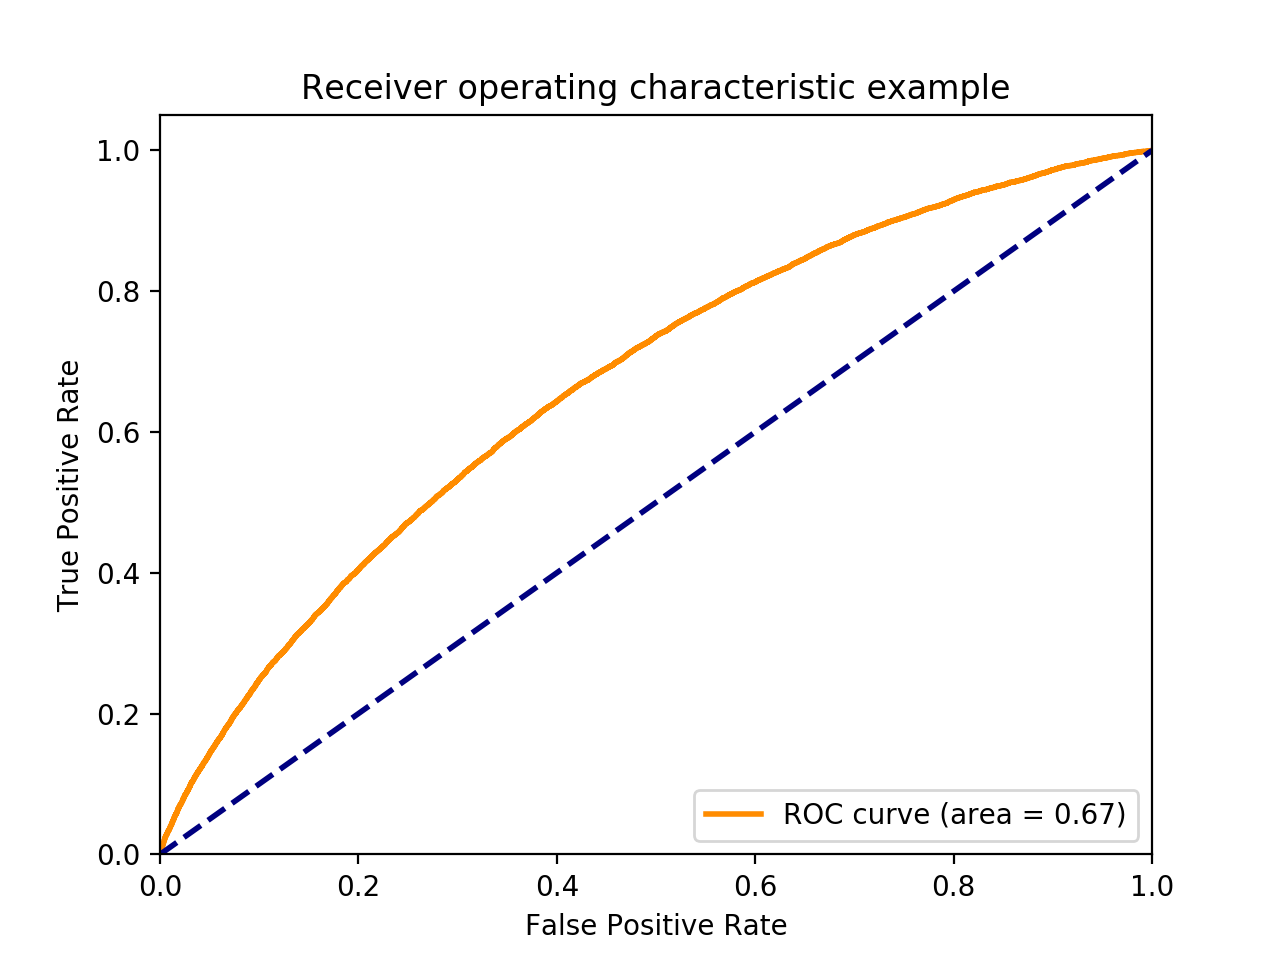

Confusion Matrix: 
 [[84578 55418]
 [ 3789  6713]]


In [71]:
# Get the performance metrics for the training data
train_preds = lr.predict(x_train)
train_preds_probs = lr.predict_proba(x_train)

# Determine the ROC-AUC values
train_fpr, train_tpr, train_thresholds = roc_curve(y_train, train_preds_probs[:,1])
train_score = roc_auc_score(y_train, train_preds_probs[:, 1])

# Plot the ROC
fig, ax = plt.subplots()
lw = 2
plt.plot(train_fpr, train_tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % train_score)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# Determine the confusion matrix
train_cfm = confusion_matrix(y_train, train_preds)
print("Confusion Matrix: \n", train_cfm)

### Performance metrics on the validation data

<IPython.core.display.Javascript object>


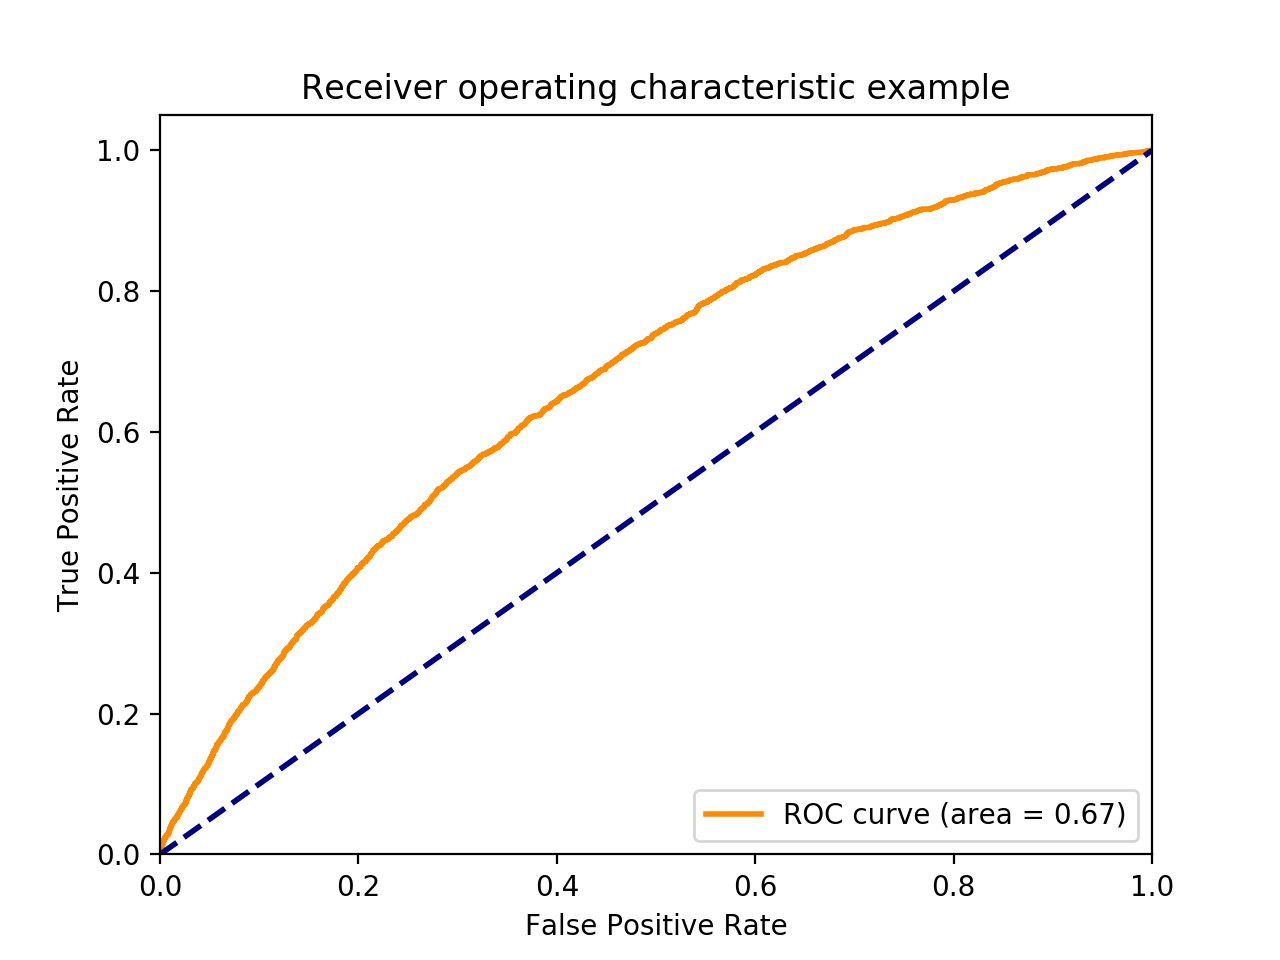

Confusion Matrix: 
 [[21222 13777]
 [  953  1673]]


In [72]:
# Get the performance metrics on the validation data
preds = lr.predict(x_val)
preds_probs = lr.predict_proba(x_val)

# Determine the ROC-AUC values
fpr, tpr, thresholds = roc_curve(y_val, preds_probs[:,1])
score = roc_auc_score(y_val, preds_probs[:, 1])

# Plot the ROC
fig, ax = plt.subplots()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % score)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# Determine the confusion matrix
cfm = confusion_matrix(y_val, preds)
print("Confusion Matrix: \n", cfm)

## Process test data

In [73]:
# Read in data
test_data_filename = 'testing_data.csv'
test_data = pd.read_csv(test_data_filename, skiprows=1)

/Users/ankurmanikandan/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (3,4,5,6,8,9,10,16) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [74]:
test_data.head(10)

,id,member_id,loan_amnt,term,int_rate,emp_length,home_ownership,annual_inc,loan_status,desc,...,bc_util,dti,inq_last_6mths,mths_since_recent_inq,revol_util,total_bc_limit,total_pymnt,mths_since_last_major_derog,tot_hi_cred_lim,tot_cur_bal
0,20159237,22421876.0,10000.0,36 months,22.15%,8 years,RENT,37000.0,Current,NaN,...,83.0,28.51,1.0,3.0,73.1%,16200.0,382.6900,NaN,14877.170282,36809.0
1,20088512,22351142.0,1400.0,36 months,18.24%,6 years,RENT,41000.0,Current,NaN,...,0.0,26.58,0.0,9.0,11.5%,4000.0,65.7900,NaN,4097.304770,19536.0
2,20138199,22400842.0,7000.0,36 months,12.49%,3 years,RENT,68900.0,Current,NaN,...,75.9,6.60,0.0,11.0,48.1%,11900.0,234.1500,80.0,12688.495161,241465.0
3,20158360,22421039.0,18000.0,60 months,16.29%,9 years,MORTGAGE,41000.0,Current,NaN,...,61.1,20.61,1.0,0.0,38.1%,7600.0,881.0200,73.0,7908.799817,179757.0
4,20127968,22390638.0,12000.0,36 months,12.99%,10+ years,MORTGAGE,64000.0,Current,NaN,...,67.0,24.61,0.0,NaN,57.9%,21000.0,808.5400,NaN,19378.561062,31953.0
5,20077585,22340282.0,6900.0,36 months,11.67%,8 years,RENT,70000.0,Fully Paid,NaN,...,23.8,8.52,0.0,20.0,28.1%,29800.0,6967.1025,NaN,28395.922806,15100.0
6,12586984,14599155.0,7250.0,36 months,16.29%,4 years,MORTGAGE,90000.0,Current,NaN,...,39.7,6.59,3.0,1.0,25.1%,2400.0,511.8600,NaN,2441.213440,25914.0
7,20047278,22310007.0,3850.0,36 months,16.99%,2 years,RENT,28000.0,Current,NaN,...,65.3,16.25,1.0,2.0,50.2%,4000.0,274.5000,NaN,4241.186825,9603.0
8,20167173,22429914.0,32225.0,60 months,22.15%,9 years,RENT,77000.0,Current,NaN,...,81.5,26.48,2.0,6.0,72.3%,23300.0,1785.5400,NaN,23427.330456,54468.0
9,20107159,22369906.0,10000.0,36 months,16.29%,< 1 year,MORTGAGE,60000.0,Current,NaN,...,7.6,9.20,3.0,1.0,8.5%,28300.0,706.0200,45.0,28799.606055,162891.0


In [75]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138735 entries, 0 to 138734
Data columns (total 22 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           138735 non-null  int64  
 1   member_id                    102505 non-null  float64
 2   loan_amnt                    138735 non-null  float64
 3   term                         102505 non-null  object 
 4   int_rate                     102505 non-null  object 
 5   emp_length                   97184 non-null   object 
 6   home_ownership               102505 non-null  object 
 7   annual_inc                   102505 non-null  float64
 8   loan_status                  102505 non-null  object 
 9   desc                         15194 non-null   object 
 10  purpose                      102505 non-null  object 
 11  percent_bc_gt_75             101459 non-null  float64
 12  bc_util                      101463 non-null  float64
 13 

In [76]:
# Process the test data
test_data, y_test = process_data(test_data, 'test')

Labels: 
 0    101529
1       976
Name: loan_status_int, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 102505 entries, 0 to 102504
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   loan_amnt              102505 non-null  float64
 1   term                   102505 non-null  object 
 2   emp_length             97184 non-null   object 
 3   home_ownership         102505 non-null  object 
 4   annual_inc             102505 non-null  float64
 5   purpose                102505 non-null  object 
 6   percent_bc_gt_75       101459 non-null  float64
 7   bc_util                101463 non-null  float64
 8   dti                    102505 non-null  float64
 9   inq_last_6mths         102505 non-null  float64
 10  mths_since_recent_inq  93677 non-null   float64
 11  revol_util             102457 non-null  object 
 12  total_bc_limit         102505 non-null  float64
 13  tot_hi_cred_lim    

### Performance metrics on the test data

<IPython.core.display.Javascript object>


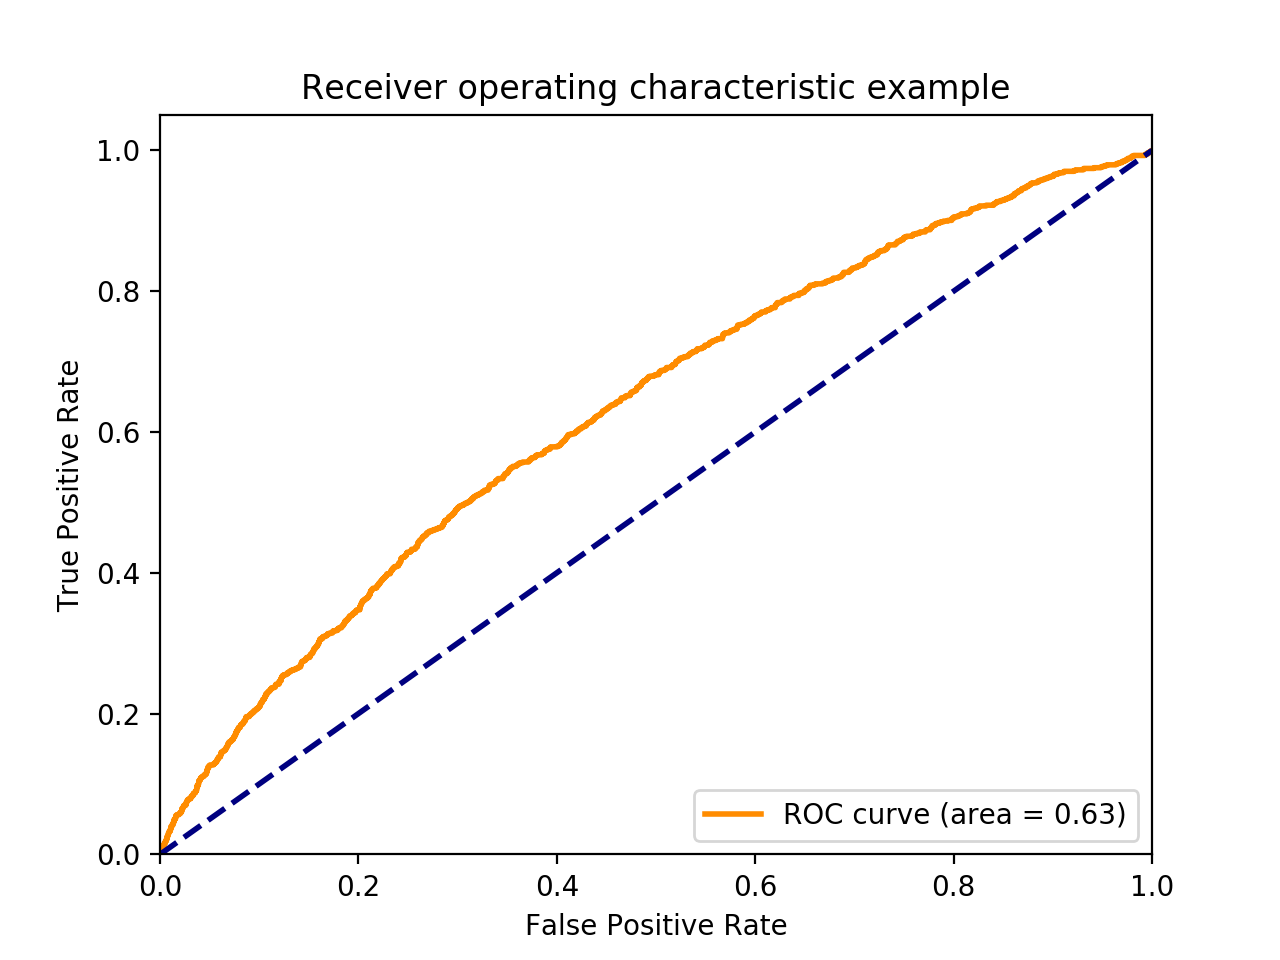

Confusion Matrix: 
 [[60763 40766]
 [  410   566]]


In [77]:
# Get predictions from the logistic regression model
test_preds = lr.predict(test_data)
test_preds_probs = lr.predict_proba(test_data)

# Determine the ROC-AUC values
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, test_preds_probs[:,1])
test_score = roc_auc_score(y_test, test_preds_probs[:, 1])

# Plot the ROC
fig, ax = plt.subplots()
lw = 2
plt.plot(test_fpr, test_tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % test_score)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# Determine the confusion matrix
test_cfm = confusion_matrix(y_test, test_preds)
print("Confusion Matrix: \n", test_cfm)

# Next Steps

## Missing values

### Categorical Variables
1. **Employment Length:** Currently, we have assigned the value 'missing' in place of the NaNs. 

### Continuous Variables
1. Assigned the median values corresponding to the loan status. 

## Model performance

The model has done a decent job. The validation metric (AUC=0.67) which is slightly greater than the test metric (AUC=0.63). The validation metric and the training metric (AUC=0.67) are the same. Multiple steps can be taken to improve the error of the model:

1. Check the summary statistics of the test dataset. I haven't done that.
2. Perform corss-validation (I have used only a single validation dataset). It'll give insights on the performance with various sample of validation data. 
3. Change the parameters of the current model.
4. Try different machine learning models.
5. Engineer more robust features.
6. The train and validation data may not be a good sample of the test data. The train and validation data must be sampled from the same distribution as the test data. [If this step would take too long, then exhaust all the steps below and if none work, then visit this step.]
7. Try advanced techniques to fill in the missing values, like KNN, EM or MICE.